Step 1: Install & Import Required Libraries

Using core data science libraries like pandas, matplotlib, and statsmodels. No external ARIMA helper packages (like `pmdarima`) are used, to avoid version conflicts.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


Step 2: Load Dataset

Using the "Daily Minimum Temperatures" dataset from Melbourne, Australia (1981–1990) to demonstrate univariate anomaly detection.


<Axes: title={'center': 'Daily Min Temperatures'}, xlabel='Date'>

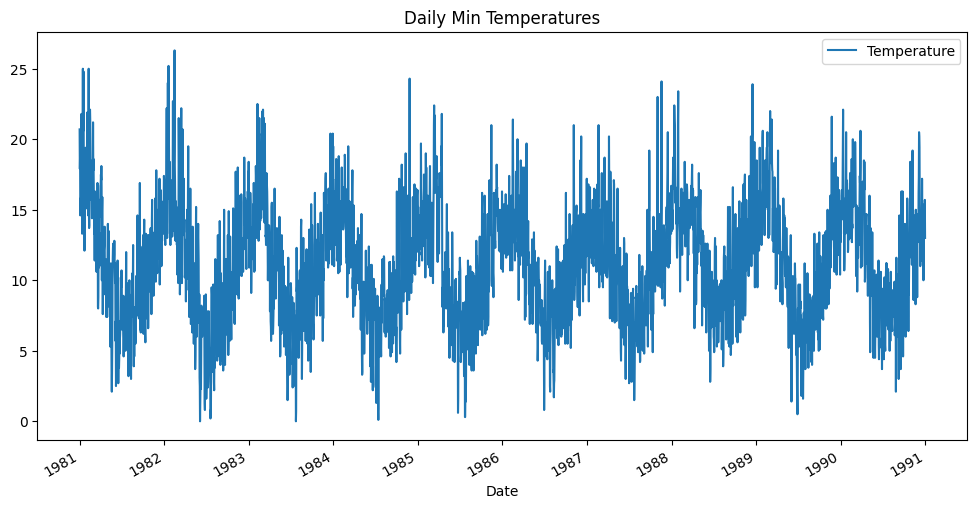

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url, parse_dates=['Date'], index_col='Date')
df.columns = ['Temperature']
df.plot(figsize=(12,6), title="Daily Min Temperatures")


Step 3: Check for Stationarity

Time series data must be stationary for ARIMA to work well. We use the Augmented Dickey-Fuller (ADF) test and also difference the series if needed.


ADF p-value: 0.0002470826300360994
ADF p-value after diff: 2.6815618226749474e-30


<Axes: title={'center': 'Differenced Series'}, xlabel='Date'>

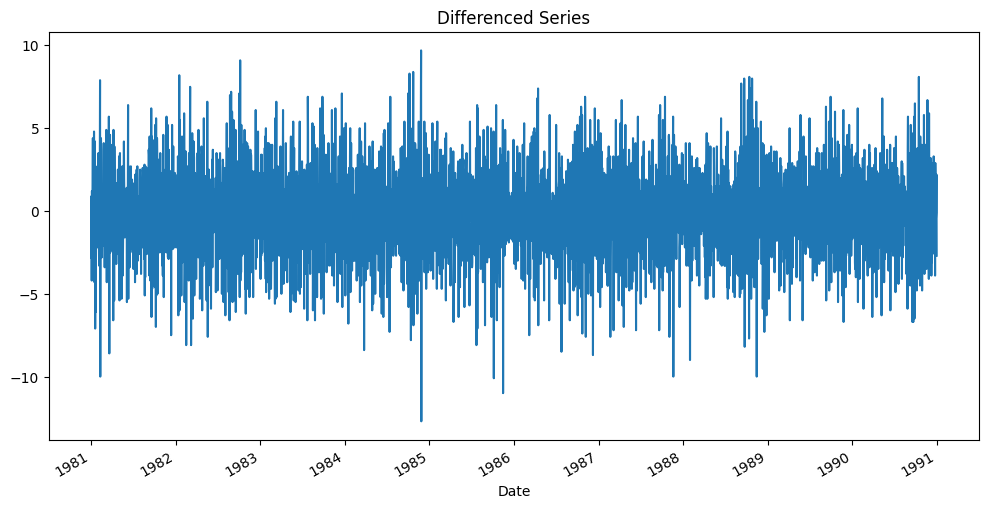

In [3]:
# ADF Test
adf_result = adfuller(df['Temperature'])
print("ADF p-value:", adf_result[1])

# Differencing if needed
df['diff'] = df['Temperature'].diff()
df.dropna(inplace=True)

# Re-test
print("ADF p-value after diff:", adfuller(df['diff'])[1])

df['diff'].plot(figsize=(12,6), title="Differenced Series")


Step 4: Choose ARIMA Parameters (p, d, q)

We visually inspect the ACF and PACF plots to select the order of ARIMA. For this example, we'll try ARIMA(2,1,2).


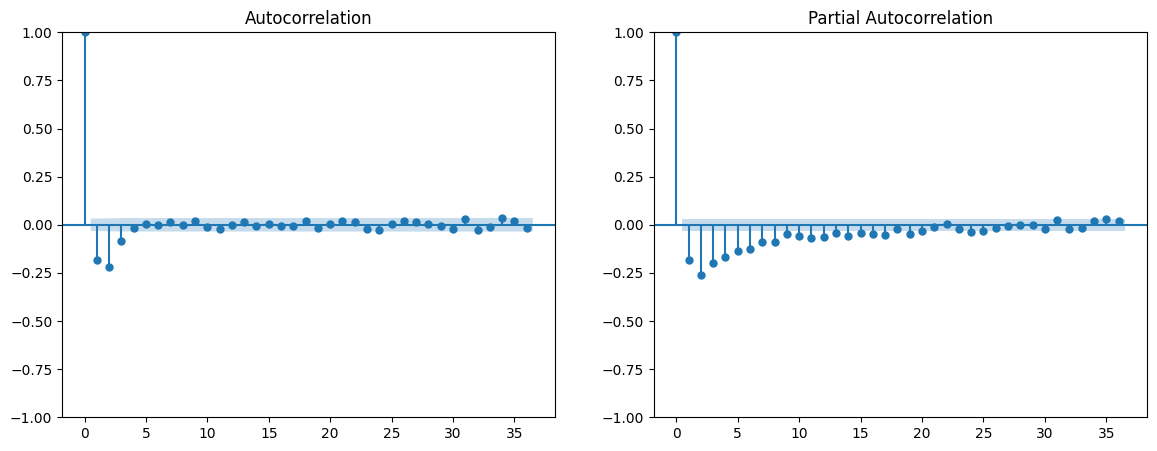

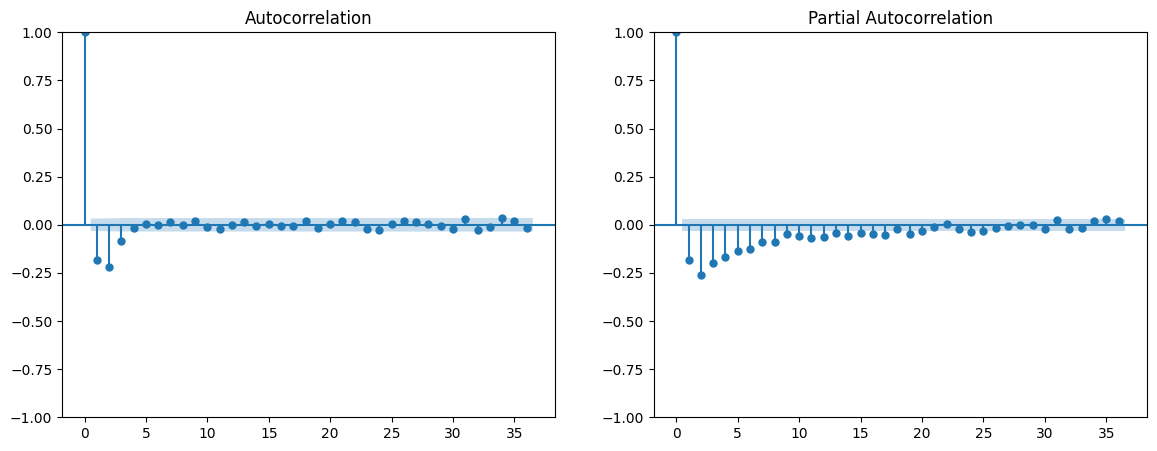

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(df['diff'], ax=ax[0])
plot_pacf(df['diff'], ax=ax[1])


Step 5: Fit ARIMA Model and Forecast

Fitting the model on the temperature data and generate in-sample forecasts. We'll also align the predictions to the original index.


In [20]:
# Refit ARIMA
model = ARIMA(df['Temperature'], order=(2,1,2))
model_fit = model.fit()

# Generate forecast for in-sample values — up to len(df)-1
forecast = model_fit.predict(start=df.index[1], end=df.index[-1])

# Create a forecast column and assign with matching index
df['forecast'] = np.nan
df.loc[forecast.index, 'forecast'] = forecast.values


Step 6: Detect Anomalies Using Residuals

Defining anomalies as points where the residual (actual - predicted) exceeds 2 standard deviations.


Text(0.5, 1.0, 'ARIMA-Based Anomaly Detection')

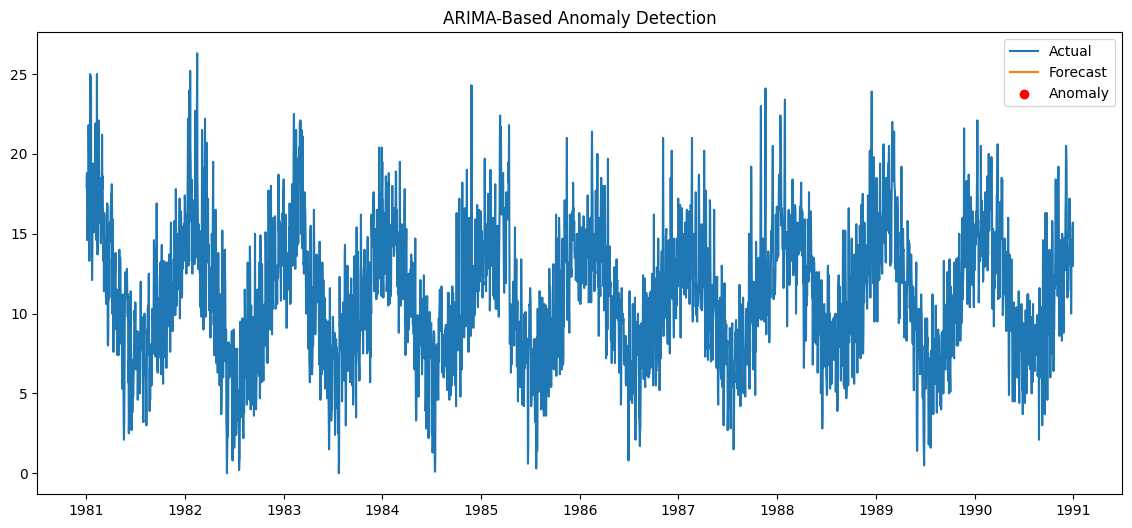

In [6]:
df['residual'] = df['Temperature'] - df['forecast']
threshold = 2 * df['residual'].std()
df['anomaly'] = np.where(np.abs(df['residual']) > threshold, True, False)

# Plot anomalies
plt.figure(figsize=(14,6))
plt.plot(df['Temperature'], label='Actual')
plt.plot(df['forecast'], label='Forecast')
plt.scatter(df[df['anomaly']].index, df[df['anomaly']]['Temperature'], color='red', label='Anomaly')
plt.legend()
plt.title("ARIMA-Based Anomaly Detection")


Step 7: Evaluate Forecast Accuracy and Save Results

Calculatinf RMSE and MAE, then export the detected anomalies to a CSV file.

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Drop rows with NaNs
df_metrics = df[['Temperature', 'forecast']].dropna()

# Check how many samples are left
print("Samples available:", len(df_metrics))

# Convert to arrays
y_true = df_metrics['Temperature'].values
y_pred = df_metrics['forecast'].values

# Compute error
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)

print("✅ RMSE:", np.sqrt(mse))
print("✅ MAE:", mae)


Samples available: 3648
✅ RMSE: 2.4090478098069967
✅ MAE: 1.8945279178756735


In [9]:
df[df['anomaly']].to_csv("anomalies_detected.csv")
df[df['anomaly'] == True].head()



,Temperature,diff,forecast,residual,anomaly
Date,,,,,


Step 8: Confidence Intervals for Forecasts

Adding upper/lower bounds to visualize uncertainty

Text(0.5, 1.0, 'ARIMA Forecast with Confidence Interval')

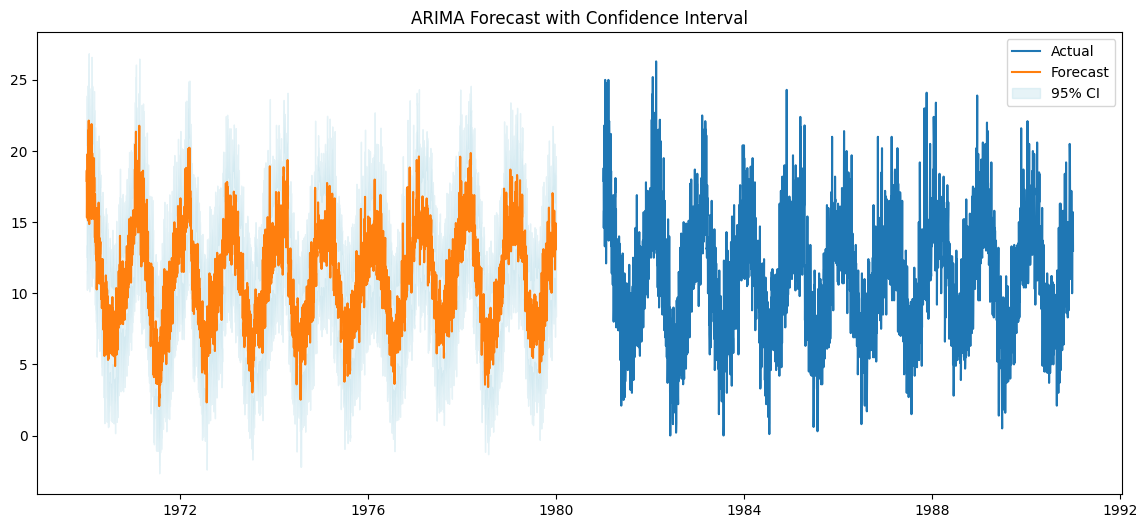

In [10]:
pred = model_fit.get_prediction(start=1, end=len(df))
ci = pred.conf_int()

plt.figure(figsize=(14,6))
plt.plot(df['Temperature'], label='Actual')
plt.plot(pred.predicted_mean, label='Forecast')
plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='lightblue', alpha=0.3, label='95% CI')
plt.legend()
plt.title("ARIMA Forecast with Confidence Interval")


In [12]:
print("NaNs in Temperature:", df['Temperature'].isna().sum())
print("NaNs in Forecast:", df['forecast'].isna().sum())



NaNs in Temperature: 0
NaNs in Forecast: 3649


DASHBOARD/INTERACTIVE VISUALS

In [17]:
pip install plotly


In [18]:
import plotly.express as px
fig = px.line(df.reset_index(), x='Date', y='Temperature', title='Interactive Temp Plot')
fig.show()
